In [0]:
### FIRST THING FIRST COMES AUTHENTICATION
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 6.4MB/s 


In [0]:
fileTraining = drive.CreateFile({'id': '1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA'}) 
fileTraining.GetContentFile(fileTraining['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileTraining['title'], fileTraining['id']))


fileGroundTruth = drive.CreateFile({'id': '18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw'}) 
fileGroundTruth.GetContentFile(fileGroundTruth['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileGroundTruth['title'], fileGroundTruth['id']))



# file train
# https://drive.google.com/open?id=1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA
# file groundtruth
# https://drive.google.com/open?id=18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw




Uploaded training_data.zip, id 1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA
Uploaded ground_truth_data.zip, id 18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw
Uploaded myunet_saved.hdf5, id 1y1CRLYcb2zqqdmF3XSr3kQ9k3HurrkdQ


In [0]:
!unzip ground_truth_data
!unzip training_data

Archive:  ground_truth_data.zip
  inflating: training_sa_crop_pat5-label.nii  
  inflating: training_sa_crop_pat6-label.nii  
  inflating: training_sa_crop_pat7-label.nii  
  inflating: training_sa_crop_pat8-label.nii  
  inflating: training_sa_crop_pat9-label.nii  
  inflating: training_sa_crop_pat0-label.nii  
  inflating: training_sa_crop_pat1-label.nii  
  inflating: training_sa_crop_pat2-label.nii  
  inflating: training_sa_crop_pat3-label.nii  
  inflating: training_sa_crop_pat4-label.nii  
Archive:  training_data.zip
  inflating: training_sa_crop_pat6.nii  
  inflating: training_sa_crop_pat7.nii  
  inflating: training_sa_crop_pat8.nii  
  inflating: training_sa_crop_pat9.nii  
  inflating: training_sa_crop_pat0.nii  
  inflating: training_sa_crop_pat1.nii  
  inflating: training_sa_crop_pat2.nii  
  inflating: training_sa_crop_pat3.nii  
  inflating: training_sa_crop_pat4.nii  
  inflating: training_sa_crop_pat5.nii  
unzip:  cannot find or open pesi_fcn_unet, pesi_fcn_unet.zip

In [0]:
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_prediction
import matplotlib.pyplot as plt_maschera
from google.colab.patches import cv2_imshow
from keras import backend as K
from keras import layers
from keras.layers import Activation
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image
from keras.preprocessing.image import load_img
import numpy as np
import nibabel as nib
from google.colab import files
from PIL import Image
import PIL.ImageOps  
from scipy.ndimage import zoom
from keras import losses

Using TensorFlow backend.


In [0]:
img_rows = 128
img_cols = 160

array_training = np.zeros((207,128,160))
array_gt = np.zeros((207,128,160))

for x in range (10):
  img_training = nib.load('../content/training_sa_crop_pat%d.nii' % (x))
  img_gt = nib.load('../content/training_sa_crop_pat%d-label.nii' % (x))
  array_img_training = np.array(img_training.dataobj)
  array_img_gt = np.array(img_gt.dataobj)
  array_img_training=np.swapaxes(array_img_training,0,1)
  array_img_gt=np.swapaxes(array_img_gt,0,1)
  print("shape img training %d: " % (x))
  print(array_img_training.shape)
  print("shape img gt %d: " % (x))
  print(array_img_gt.shape)
  
  array_img_training = zoom(array_img_training, (1, 128/array_img_training.shape[1], 160/array_img_training.shape[2]))
  array_img_gt = zoom(array_img_gt, (1, 128/array_img_gt.shape[1], 160/array_img_gt.shape[2]))
  print("NUOVO shape img training %d: " % (x))
  print(array_img_training.shape)
  print("NUOVO shape img gt %d: " % (x))
  print(array_img_gt.shape)
  if (x == 0):
    array_training = array_img_training
    array_gt = array_img_gt
  else :
    array_training = np.concatenate((array_training, array_img_training), axis = 0)
    array_gt = np.concatenate((array_gt, array_img_gt), axis = 0)
    
print("--> shape array training finale concatenato: ")
print(array_training.shape)
print("--> shape array gt finale concatenato: ")
print(array_gt.shape)
  
array_training = array_training.reshape((array_training.shape[0], array_training.shape[1], array_training.shape[2],1))

#preprocessing delle immagini
array_training = array_training.astype('float32')
mean = np.mean(array_training)
std = np.std(array_training)

array_training -= mean
array_training /= std


shape img training 0: 
(207, 127, 151)
shape img gt 0: 
(207, 127, 151)
NUOVO shape img training 0: 
(207, 128, 160)
NUOVO shape img gt 0: 
(207, 128, 160)
shape img training 1: 
(220, 127, 160)
shape img gt 1: 
(220, 127, 160)
NUOVO shape img training 1: 
(220, 128, 160)
NUOVO shape img gt 1: 
(220, 128, 160)
shape img training 2: 
(231, 118, 190)
shape img gt 2: 
(231, 118, 190)
NUOVO shape img training 2: 
(231, 128, 160)
NUOVO shape img gt 2: 
(231, 128, 160)
shape img training 3: 
(175, 150, 148)
shape img gt 3: 
(175, 150, 148)
NUOVO shape img training 3: 
(175, 128, 160)
NUOVO shape img gt 3: 
(175, 128, 160)
shape img training 4: 
(105, 95, 130)
shape img gt 4: 
(105, 95, 130)
NUOVO shape img training 4: 
(105, 128, 160)
NUOVO shape img gt 4: 
(105, 128, 160)
shape img training 5: 
(120, 97, 164)
shape img gt 5: 
(120, 97, 164)
NUOVO shape img training 5: 
(120, 128, 160)
NUOVO shape img gt 5: 
(120, 128, 160)
shape img training 6: 
(230, 150, 170)
shape img gt 6: 
(230, 150, 1

In [0]:
def dice_coef(y_true, y_pred, smooth=0.0):
    """Average dice coefficient per batch."""
    axes = (1, 2, 3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)
  

     
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
def up_conv_block(input_tensor, kernel_size, filters, stage, block, strides=(1, 1)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    up_conv_name_base = 'up' + str(stage) + block + '_branch'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = UpSampling2D(size=(2, 2), name=up_conv_name_base + '2a')(input_tensor)

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(x)

    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = UpSampling2D(size=(2, 2), name=up_conv_name_base + '1')(input_tensor)
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(shortcut)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x
  
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


In [0]:
def get_resnet(f=16, bn_axis=3, classes=3):
    input = Input((img_rows, img_cols, 1))
    x = ZeroPadding2D((4, 4))(input)
    
    x = Conv2D(f, (7, 7), strides=(2, 2), name='conv1')(x)

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = conv_block(x, 3, [f, f, f * 2], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f, f, f * 2], stage=2, block='b')
    x2 = identity_block(x, 3, [f, f, f * 2], stage=2, block='c')

    x = conv_block(x2, 3, [f * 2, f * 2, f * 4], stage=3, block='a')
    x = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='b')
    x3 = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='d')

    x = conv_block(x3, 3, [f * 4, f * 4, f * 8], stage=4, block='a')
    x = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='b')
    x4 = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='f')

    x = conv_block(x4, 3, [f * 8, f * 8, f * 16], stage=5, block='a')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='b')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='c')

    x = up_conv_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='a')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='b')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='c')
    
    x = concatenate([x, x4], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='a')
    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='b')

    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='f')
    x = concatenate([x, x3], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='a')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='b')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='d')
    x = concatenate([x, x2], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 4, f, f], stage=10, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='b')
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='c')

    x = UpSampling2D(size=(2, 2))(x)
    #x = Conv2D(classes, (3, 3), padding='same', activation='sigmoid', name='convLast')(x)
    x = Conv2D(classes, (3, 3), padding='same', activation='softmax', name='convLast')(x)

    model = Model(input, x, name='resnetUnet')

    #model.compile(optimizer=Adam( lr=3e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.compile(optimizer=Adam( lr=0.01), loss= losses.categorical_crossentropy, metrics=[dice_coef, 'accuracy'])
       # model.compile(optimizer=Adam(lr=3e-4), loss=dice_coef_loss,
        #          metrics=[dice_coef, 'accuracy', precision, recall, f1score])

    model.summary()

    return model

In [0]:
#realizza il modello Unet per 3 classi
model = get_resnet(f=16, bn_axis=3, classes=3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 160, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 136, 168, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 65, 81, 16)   800         zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 65, 81, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
from keras.utils import to_categorical


# suddivisione del dataset in 70% training e 30% test
#x_train = array_training[0:1350]
#x_test = array_training[1351:1928]

#suddivisione del dataset in 7 pazienti per il training e 3 per il test
x_train = array_training[0:1288]
x_test = array_training[1288:1928]
print(x_train.shape)
print(x_test.shape)

#y_train = array_gt[0:1350]
#y_test = array_gt[1351:1928]

y_train = array_gt[0:1288]
y_test = array_gt[1288:1928]

# one hot encoding con tensorflow per 3 classi
import tensorflow as tf
n_classes = 3 
tensor=tf.one_hot(y_train, n_classes)   

#trasformaiamo il tensor in numpy array
with tf.Session() as sess:
   y_train_ohe=sess.run(tensor)



(1288, 128, 160, 1)
(640, 128, 160, 1)


In [0]:
# alleniamo il modello
results = model.fit(x_train, y_train_ohe,validation_split=0.2 ,batch_size=16,epochs=50)

Train on 1030 samples, validate on 258 samples
Epoch 1/50
1030/1030 [==============================] - 51s 49ms/step - loss: 0.3290 - dice_coef: 0.8304 - acc: 0.8785 - val_loss: 0.3019 - val_dice_coef: 0.8711 - val_acc: 0.8902
Epoch 2/50
1030/1030 [==============================] - 21s 21ms/step - loss: 0.1815 - dice_coef: 0.9010 - acc: 0.9305 - val_loss: 0.2810 - val_dice_coef: 0.8895 - val_acc: 0.9049
Epoch 3/50
1030/1030 [==============================] - 21s 21ms/step - loss: 0.1434 - dice_coef: 0.9217 - acc: 0.9456 - val_loss: 0.3020 - val_dice_coef: 0.8998 - val_acc: 0.9115
Epoch 4/50
1030/1030 [==============================] - 22s 21ms/step - loss: 0.1167 - dice_coef: 0.9362 - acc: 0.9557 - val_loss: 0.3391 - val_dice_coef: 0.9119 - val_acc: 0.9160
Epoch 5/50
1030/1030 [==============================] - 40s 39ms/step - loss: 0.1113 - dice_coef: 0.9395 - acc: 0.9582 - val_loss: 0.2375 - val_dice_coef: 0.9256 - val_acc: 0.9321
Epoch 6/50
1030/1030 [==============================]

In [0]:

print(results.history.keys())

# summarize history for loss
plt.plot(results.history['val_acc'])
plt.title('validation accuracy')
plt.ylabel('val_acc')
plt.xlabel('epoch')
plt.legend('val_acc', loc='upper left')
plt.show()


# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()



In [0]:
import matplotlib.pyplot as plt
# testa il modello
predicted_image = model.predict(x_test, verbose = 0)






In [0]:
#funzione dice con numpy arrays
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum
  
  

Dice coefficient del slice: 
-->  0.9396213657876944


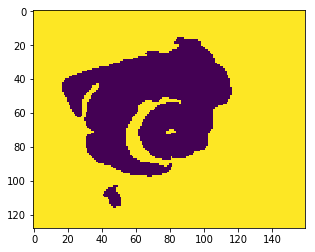

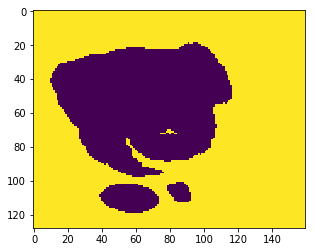

In [0]:
# risultato della predizione, slice 0 con label = 0

# round di tutti i valori della predizione
predicted_image=np.round(predicted_image,0)


image = (predicted_image[126][:, :,0] * 255.).astype(np.uint8)

test=tf.one_hot(y_test,3) 
with tf.Session() as sess:
   d=sess.run(test)
image1 = (d[126][:, :,0] * 255.).astype(np.uint8)

yy_pred=image
yy_test=image1

print("Dice coefficient del slice: ")
print("--> ",dice(yy_pred,yy_test))

img = Image.fromarray(image)  
#plot result prediction
plt_prediction.imshow(img)
plt_prediction.show()



# maschera, slice 0 con label = 0 (prima ne facciamo il one-hot-encoding)


img = Image.fromarray(image1)
plt_maschera.imshow(img)
#print ground truth
plt_maschera.show()

Dice coefficient del slice: 
-->  0.4166273027869627


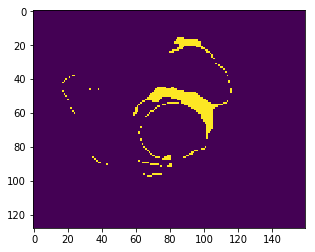

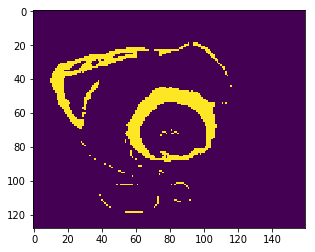

In [0]:
# risultato della predizione, slice 0 con label = 1
image = (predicted_image[126][:, :,1] * 255.).astype(np.uint8)
img = Image.fromarray(image)

test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)
image1 = (d[126][:, :,1] * 255.).astype(np.uint8)


yy_pred=image
yy_test=image1
print("Dice coefficient del slice: ")
print("--> ",dice(yy_pred,yy_test))

plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 1 (prima ne facciamo il one-hot-encoding)

img = Image.fromarray(image1)
plt_maschera.imshow(img)
plt_maschera.show()

Dice coefficient del slice: 
-->  0.8994743758212878


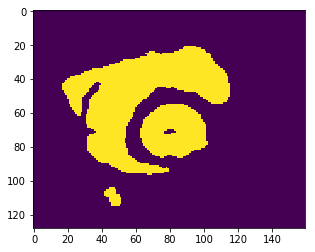

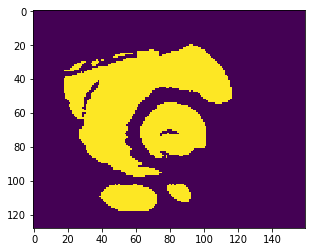

In [0]:
# risultato della predizione, slice 0 con label = 2
image = (predicted_image[126][:, :,2] * 255.).astype(np.uint8)
img = Image.fromarray(image) 


test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image1 = (d[126][:, :,2] * 255.).astype(np.uint8)


yy_pred=image
yy_test=image1
print("Dice coefficient del slice: ")
print("--> ",dice(yy_pred,yy_test))


plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 2 (prima ne facciamo il one-hot-encoding)

img = Image.fromarray(image1)
plt_maschera.imshow(img)
plt_maschera.show()

In [0]:
predicted_image=np.round(predicted_image,0)

somma = 0
array_dice_background = []

for i in range(0,639):
  image = (predicted_image[i][:, :,0] * 255.).astype(np.uint8)
  image1 = (d[i][:, :,0] * 255.).astype(np.uint8)
  yy_pred=image
  yy_test=image1
  dice_slice = dice(yy_pred,yy_test)
  somma += dice_slice
  array_dice_background.append(dice_slice)

print("Dice medio per il Background:   ", somma/640)
d_standard = np.std(array_dice_background)
print("Deviazione standard-Background: ", d_standard)


print("--------------------->")

somma = 0
array_dice_miocardio = []

for i in range(0,639):
  image = (predicted_image[i][:, :,1] * 255.).astype(np.uint8)
  image1 = (d[i][:, :,1] * 255.).astype(np.uint8)
  yy_pred=image
  yy_test=image1
  dice_slice = dice(yy_pred,yy_test)
  somma += dice_slice
  array_dice_miocardio.append(dice_slice)

print("Dice medio per il Miocardio:   ", somma/640)
deviazione_standard = np.std(array_dice_miocardio)
print("Deviazione standard-Miocardio: ", deviazione_standard)
print("------------------------->")

somma = 0
array_dice_bloodpool = []

for i in range(0,639):
  image = (predicted_image[i][:, :,2] * 255.).astype(np.uint8)
  image1 = (d[i][:, :,2] * 255.).astype(np.uint8)
  yy_pred=image
  yy_test=image1
  dice_slice = dice(yy_pred,yy_test)
  somma += dice_slice
  array_dice_bloodpool.append(dice_slice)

print("Dice medio per il blood Pool:   ", somma/640)
deviazione_standard = np.std(array_dice_bloodpool)
print("Deviazione standard-Blood Pool: ", deviazione_standard)
print("---------------------------->")




Dice medio per il Background:    0.9492458252066923
Deviazione standard-Background:  0.03983112413960627
--------------------->
Dice medio per il Miocardio:    0.2847582730647297
Deviazione standard-Miocardio:  0.28126108072740763
------------------------->
Dice medio per il blood Pool:    0.7416384239668881
Deviazione standard-Blood Pool:  0.279067831179658
---------------------------->


In [0]:

def calcolo_voxel_bloodpool(array):
  print(array.shape)
  total = 0
  slices = array.shape[0]
  rows = array.shape[1]
  columns = array.shape[2]
  
  for slice in range(slices):
    for row in range(rows):
      for column in range(columns):
        print(slice,row,column)
        if (np.any(array[slice][row, column, 0] == 2)):
          total+=1
          print('voxel trovato!')
  return total
  
  
  def calcolo_voxel_bloodpool1(array):
    result = np.where(array == 2)
    print(result)
 







In [0]:
prediction_paziente_7 = predicted_image[0:250]
prediction_paziente_7 = zoom(prediction_paziente_7, (1, 165/prediction_paziente_7.shape[1], 200/prediction_paziente_7.shape[2], 1))

In [0]:
prediction_paziente_8 = predicted_image[250:440]
prediction_paziente_8 = zoom(prediction_paziente_8, (1, 140/prediction_paziente_8.shape[1], 150/prediction_paziente_8.shape[2], 1))

In [0]:
prediction_paziente_9 = predicted_image[440:640]
prediction_paziente_9 = zoom(prediction_paziente_9, (1, 170/prediction_paziente_9.shape[1], 165/prediction_paziente_9.shape[2], 1))

In [0]:
import numpy.ma as ma


prediction_paziente_7 = predicted_image[0:250]
prediction_paziente_8 = predicted_image[250:440]
prediction_paziente_9 = predicted_image[440:640]

# print(prediction_paziente_7.shape)
# print(prediction_paziente_7[0][0,0,0])
print("---------------------------->")

num_voxel_bloodpool_7 =np.sum(prediction_paziente_7[:,:,:,2])
num_voxel_bloodpool_8 =np.sum(prediction_paziente_8[:,:,:,2])
num_voxel_bloodpool_9 =np.sum(prediction_paziente_9[:,:,:,2])

#num_voxel_bloodpool_7 =np.sum(calcolo_voxel_bloodpool(prediction_paziente_7))
#num_voxel_bloodpool_8 =np.sum(calcolo_voxel_bloodpool(prediction_paziente_8))
#num_voxel_bloodpool_9 =np.sum(calcolo_voxel_bloodpool(prediction_paziente_9))


dictionary_num_voxels_prediction = {
    7 : num_voxel_bloodpool_7,
    8 : num_voxel_bloodpool_8,
    9 : num_voxel_bloodpool_9
}

error_vet = np.arange(3)
for x in range (7,10):
  print("--> Paziente", x,":")
  img_gt = nib.load('../content/training_sa_crop_pat%d-label.nii' % (x))
  dx,dy,dz= img_gt.header['pixdim'][1:4]
  
#   print("valori dx,dy,dz: ",dx,dy,dz)
  
  
  volume_per_voxel=dx*dy*dz* 1e-3
  
  #numero totale di voxel
  
  num_voxel_gt =np.sum(img_gt.get_data() == 2)
  
  volume_gt = volume_per_voxel * num_voxel_gt
  
  volume_prediction = volume_per_voxel * dictionary_num_voxels_prediction[x]
  
  print("\nVolume cuore GROUND TRUE: ")
  print("-->",volume_gt)
  print("Volume cuore PREDICTION: ")
  print("-->",volume_prediction)
  print("------------------------------->")
  error=volume_gt-volume_prediction
  error_vet[x-7]=error
  
  #sommare tutti errori
somma=0
for x in range(0,error_vet.size):
  somma=somma+error_vet[x]
mae=somma/error_vet.size

print("mae: ",mae,"ml")

---------------------------->
--> Paziente 7 :

Volume cuore GROUND TRUE: 
--> 445.55227017661934
Volume cuore PREDICTION: 
--> 245.159910443455
------------------------------->
--> Paziente 8 :

Volume cuore GROUND TRUE: 
--> 355.71980225539204
Volume cuore PREDICTION: 
--> 349.68586358618734
------------------------------->
--> Paziente 9 :

Volume cuore GROUND TRUE: 
--> 622.2150389373302
Volume cuore PREDICTION: 
--> 438.12548686051366
------------------------------->
mae:  130.0 ml


In [0]:
print(prediction_paziente_9.shape)

(200, 170, 165, 3)


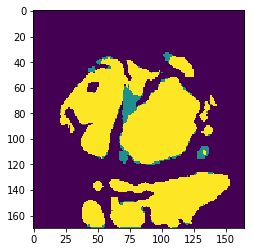

In [0]:
prediction_reversed_9 = np.argmax(prediction_paziente_9, axis=3)
image1 = (prediction_reversed_9[126][:, :] * 255.)
img = Image.fromarray(image1)
plt_maschera.imshow(img)
plt_maschera.show()

In [0]:
#prediction_riconv = zoom(prediction_reversed_9, (1, 170/prediction_reversed_9.shape[1], 165/prediction_reversed_9.shape[2]))
prediction_reversed_swappato=np.swapaxes(prediction_reversed_9,1,0)
print(prediction_reversed_swappato.shape)


(170, 200, 165)


In [0]:
# new_image.save("paziente7.nii")


import nibabel as nib
import numpy as np


new_image = nib.Nifti1Image(prediction_reversed_swappato, affine=np.eye(4))
new_image.set_data_dtype(dtype=np.uint8)

import nibabel as nib


nib.save(new_image, 'predict3D_paziente_9_myunet')